### Apendix A. Data Preparation

As a part of the data preparation, labeled training images are standardized in terms of its orientation and dimensions. The number of dataset is increased by augmentation. The data is then saved into a csv file for later retrieval. 


**Table of Contents**

1. Standardize image characteristics (i.e., orientation and size)
2. Augment datasets
3. Retrieve and regenerate images from the saved csv file
4. Combine csv Files of the Individual Objects into a Single DataFrame  
5. Summary  

***

#### 1. Standardize image characteristics (i.e., orientation and size)    

Given a set of labeled training images, the first step is to standardize the image orientation and size. It is assumed that the image initially has the following dimensions: 4128x2322 pixels.

In [1]:
import cv2
import matplotlib.pyplot as plt

#image paths
images=["Images/spoon/spoon_2.jpg","Images/fork/fork_2.jpg", "Images/floss/floss_2.jpg"]
#image labels
label_dict_key=['1','2','3']
label_dict={'1':'(a) Spoon','2':'(b) Fork','3':'(c) Floss'}

for i,image in enumerate(images):
    plt.subplot(1,3,i+1)
    img=cv2.imread(image)
    plt.imshow(img)
    plt.title(label_dict[label_dict_key[i]])
    plt.axis('off') #turn off axes
plt.show()


<Figure size 640x480 with 3 Axes>

In [2]:
import cv2
import numpy as np

#check original dimensions
img_test=cv2.imread("Images/spoon/spoon_1.jpg")

#img_test=img_test.flatten()
img_test.shape

(4128, 2322, 3)

#### 1.1. Create a function that resize the images and makes sure that the orientations are the same  

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#1. standardize images
def create_standardized_image(img_filename):
    """
    Accepts a colored image as an input and returns a 2D array of a shrunk image (to 2% of its original size) 
    input 
        filename: specify image filename and path
    output
        returns a 2d numpy array of the gray image
    """
        
    #a. read image file
    img=cv2.imread(img_filename)

    #b. resize image to 2.5% its original dimensions
    img = cv2.resize(img, (0,0), fx=0.025, fy=0.025)

    #c. change image to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #don't gray the image
    
    #check
    #plt.imshow(gray) 
    #plt.show()

    x,y,z=img.shape #get image dimensions
    #print(x,y) #check

    #d. check image orientation. If vertically oriented, rotate it 90 degrees
    if x > y:
        #rotate image by 90 degrees
        rotated = imutils.rotate_bound(img, 90)
        
        #resize image
        rotated = cv2.resize(rotated, (x, y))
        
        #check
        #plt.imshow(rotated)
        #plt.title(img_filename) #add title
        #plt.show()
        
        #return a processed image
        return rotated
    
    #otherwise, just plot it out to allow a visual inspections
    else:
        
        #check
        #plt.imshow(gray)
        #plt.title(img_filename) #add title
        #plt.show()   
        
        #return a processed image
        return img

#### 1.2. Augment datasets  

To increase the number of dataset, I carry out augmentation.

ref.: 
1. Rajalingappaa Shanmugamani, "Deep Learning for Computer Vision", Packt 2018, Chpt. 2: Augmentation techniques.
2. https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
3. https://keras.io/preprocessing/image/
4. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
5. https://www.youtube.com/watch?v=14syUbL16k4

The number of datasets can be increased by applying data augmentation. Data augmentation techniques include flipping, random cropping, shearing, zooming, rotation, whitening, normalization, and channel shifting. Data augmentation can be implemented using the built in tensorflow ImageGenerator method. 

In [4]:
#2. augment datasets  



def augment_datasets(df_orig, no_of_images, label_name):
    """
    Given a list of image array dataset, augment to increase the number of dataset
        
    Input:
        dataframe=a DataFrame of a flatten image array dataset
        no_of_images=number of images to augment
        label_name=label of images
    Output:
        a DataFrame of the original and the augmented dataset (i.e., the combined DataFrame)
    """
    
    #dynamically set tensorflow backend
    #https://stackoverflow.com/questions/49121112/how-do-i-set-the-keras-backend-in-python-dynamically-when-loaded-using-superviso
    import os
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    from keras import backend as K
    from keras.preprocessing.image import ImageDataGenerator

   
    df_temp=pd.DataFrame() #an empty DataFrame for storing augment image arrays 

    #prepare inputs
    df2=df_orig.iloc[:,:17922].as_matrix() #change to matrix
    X_train=df2.reshape(df2.shape[0],58,103,3) #reshape
    X_train = X_train.astype('float64')
    X_train.shape #check

    y_train=df_orig.iloc[:,5976]
    
    #define methods of data augmentation
    datagen = ImageDataGenerator(zoom_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2)

    # fit parameters from data
    datagen.fit(X_train)
        
    # configure batch size and retrieve one batch of images
    #for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=no_of_images):
    for X_batch in datagen.flow(X_train, batch_size=no_of_images):
        #plot the images to check
        for i in range(0, no_of_images): #iterate over each image
            #plot the images to check
            #plt.subplots()
            #plt.imshow(X_batch[i].reshape(58,103), cmap=plt.get_cmap('gray'))

            #for each image, augment 7 times
            #append new_image to existing DataFrame
            for j in range(0,7):
                df_temp=pd.concat([df_temp,pd.Series(X_batch[i].flatten())],axis=1)
        break

        
    df_temp=df_temp.T #transpose DataFrame
    df_temp.head() #check
    
    #combine DataFrames (i.e., original with augmented data)
    df_augment=pd.concat([df_temp,df_orig.iloc[:,:17922]],axis=0) 
    
    #add label column and rename columns
    #replace index column with numbered values 
    #https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas
    df_augment.reset_index(drop = True, inplace = True) 

    #add pixel dimensions and a label column
    df_augment['w']=df_orig.iloc[0,17922]
    df_augment['h']=df_orig.iloc[0,17923]
    df_augment['label']=label_name
    
    
    df_augment.shape #check
    df_augment.head() #check
    
    #return the combined DataFrame
    return df_augment    

#### 1.3. Create a function that creates a DataFrame of the image array

In [5]:
import glob
import imutils
import os
import pandas as pd

def create_image_DataFrame(list_of_image_filenames, no_of_images, label_name):
    """
    Given a list of images, create a DataFrame of flattened array of images
    
    Dependent functions:
        -create_standardized_image(img_filename)
        -augment_datasets(df_orig, no_of_images, label_name)
    Input:
        a list of image filenames
    Output:
        a DataFrame of the original and the augmented dataset (i.e., the combined DataFrame)
    """
    
    #create an empty DataFrame for storing the data
    df_temp=pd.DataFrame()
    
    #convert each image in a specified folder to gray
    for i in list_of_image_filenames:
        standardized_image=create_standardized_image(i)

        #save image to file
        ##cv2.imwrite(i, standardized_image)

        #get array dimensions
        img_dim=standardized_image.shape

        #flatten image
        img_flatten=standardized_image.flatten()

        #https://www.tutorialspoint.com/numpy/numpy_append.htm
        #append image dimension to the array: comb_arr
        comb_arr=np.append(img_flatten,img_dim) 

        #save flattened array to a DataFrame
        df_temp=pd.concat([df_temp,pd.Series(comb_arr)],axis=1)

    df_temp=df_temp.T #transpose data to make columns the pixel numbers
    #df_temp.head() #check  
    
    #replace index column with numbered values 
    #https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas
    df_temp.reset_index(drop = True, inplace = True) 

    #add a label column
    df_temp['label']='spoon'

    #rename last two columns
    #last two columns are image dimensions
    df_temp=df_temp.rename({17922:'w',17923:'h'}, axis='columns')
    
    return augment_datasets(df_temp, no_of_images, label_name) #return the combined augmented images DataFrame



In [6]:
import glob

#1. spoon dataset
list_of_image_filenames=glob.glob('Images/spoon/spoon_*.jpg')
df_spoon=create_image_DataFrame(list_of_image_filenames,14,'spoon')

df_spoon.shape #check
#save data to csv
df_spoon.to_csv('Data/spoon.csv',index=False)

C:\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
#2. fork dataset
list_of_image_filenames2=glob.glob('Images/fork/fork_*.jpg')
df_fork=create_image_DataFrame(list_of_image_filenames2,14,'fork')

df_fork.shape #check
#save data to csv
df_fork.to_csv('Data/fork.csv',index=False)

In [8]:
#3. floss dataset
list_of_image_filenames3=glob.glob('Images/floss/floss_*.jpg')
df_floss=create_image_DataFrame(list_of_image_filenames3,14,'floss')

df_floss.shape #check
#save data to csv
df_floss.to_csv('Data/floss.csv',index=False)

#### 3. Retrieve and regenerate images from the saved csv file
Here, I demonstrate that the saved data can be retrieved and the images can be regenerated.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#try to regenerate images from saved csv file
#https://stackoverflow.com/questions/8458315/more-elegant-way-to-create-a-2d-matrix-in-python

#import data - test
df_retr_spoon=pd.read_csv('Data/spoon.csv')
df_retr_spoon.head() #check

#df_retr_spoon.shape #check

,0,1,2,3,4,5,6,7,8,9,...,17915,17916,17917,17918,17919,17920,17921,w,h,label
0,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
1,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
2,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
3,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
4,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon


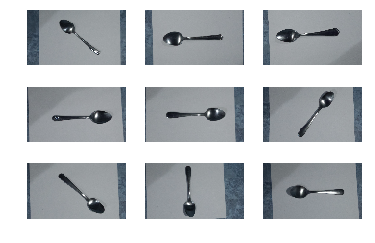

In [10]:
#reshape data
#retrieve last 9 rows, first 17922 columns and turn into a numpy array
for i in range(9):
    plt.subplot(330+1+i) 
    img_data=np.array(df_retr_spoon.iloc[len(df_retr_spoon)-9+i,:17922], dtype=int) #make sure to specify data type as float when converting to an np array
    #reshape data
    img_data=img_data.reshape(58,103,3)

    #img_data.shape #check shape
    plt.imshow(img_data)#, cmap='gray')
    plt.axis('off') #turn off axes
    
plt.show()

#### 4. Combine csv Files of the Individual Objects into a Single DataFrame

Here, we prepare two types of csv data. One contains colored images (called combined_rgb.csv) and another one contains gray images (called combined.csv). The dimensions of the colored images are 58x103 and the dimensions of the gray images are 46x83. Combined.csv is used as input for **Appendix B** and **C**, whereas combined_rgb.csv is used as input for **Appendix D**.


In [11]:
import pandas as pd

df_combined=pd.DataFrame() #an empty DataFrame to combine the individual DataFrames

df_list=['spoon','fork','floss']

for each in df_list:
    df_combined=pd.concat([df_combined,pd.read_csv('Data/%s.csv' %(each))])
df_combined.shape #check

(336, 17925)

In [12]:
df_combined.to_csv('Data/combined_rgb.csv', index=False) #save to csv. This process takes a while.

In [13]:
#retrieve data

import pandas as pd
import numpy as np

df_combined=pd.read_csv('Data/combined_rgb.csv')


In [14]:
df_combined.shape #check
df_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,17915,17916,17917,17918,17919,17920,17921,w,h,label
0,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
1,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
2,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
3,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon
4,0.297331,0.228402,0.210149,0.287152,0.217666,0.198701,0.322936,0.255408,0.238944,0.328476,...,-0.441588,-0.290018,-0.391087,-0.450395,-0.297849,-0.399347,-0.459202,58,103,spoon


In [15]:
X=df_combined.iloc[:,:17922]

X=np.array(X, dtype=float) #turn into a numpy array
X.shape #check

(336, 17922)

In [16]:
X=X.reshape(X.shape[0],58,103,3)
X.shape

(336, 58, 103, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


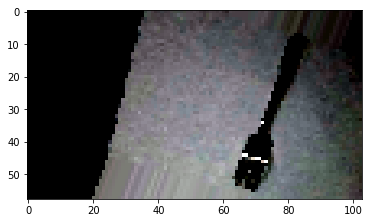

In [17]:
import matplotlib.pyplot as plt

plt.imshow(X[150].reshape(58,103,3))
plt.show()

In [18]:
#create the smaller pixels black and white version for input for machine learning, NN, and CNN models of Appendix B and C.

df_bw=pd.DataFrame() #create a blank pandas DataFrame
X.shape

(336, 58, 103, 3)

In [19]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
import numpy as np

def rgb2gray(rgb):
    """
    This function converts a colored numpy array to a grayscale numpy array, resize, and flatten the array.
    Input
        rgb=a 3d array
    Output
        gray=a 2d array
    """
    #gray the image
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    #resize the image
    gray=cv2.resize(gray,(0,0), fx=0.81, fy=0.80)
    gray=gray.flatten()
    
    return gray

#import cv2
#type(X)
gray_image=[] #create an empty list to store gray image

#convert rgb image to a grayscale 
for each in X:
    #print(each.shape) #check
    gray_image.append(rgb2gray(each))
    
gray_image=np.array(gray_image) #change list to a numpy array

In [20]:
print('image shape:', gray_image.shape) #check

image shape: (336, 3818)


[]

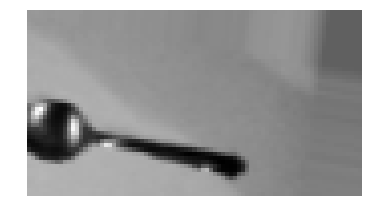

In [21]:
#check
#type(gray_im)
plt.imshow(gray_image[0].reshape(46,83), cmap='gray')
plt.axis('off')
plt.plot()

In [22]:
#convert gray_image into pandas DataFrame
df_combined_bw=pd.DataFrame(gray_image)

#add width and height columns
df_combined_bw['w']=46
df_combined_bw['h']=83

#add a label column
df_combined_bw=pd.concat([df_combined_bw,df_combined.iloc[:,17924]],axis=1)


In [23]:
#check
df_combined_bw.head()

,0,1,2,3,4,5,6,7,8,9,...,3811,3812,3813,3814,3815,3816,3817,w,h,label
0,0.244874,0.249747,0.2772,0.247191,0.20838,0.193878,0.196453,0.228995,0.209852,0.206661,...,-0.357467,-0.356567,-0.359872,-0.366566,-0.368043,-0.368676,-0.369308,46,83,spoon
1,0.244874,0.249747,0.2772,0.247191,0.20838,0.193878,0.196453,0.228995,0.209852,0.206661,...,-0.357467,-0.356567,-0.359872,-0.366566,-0.368043,-0.368676,-0.369308,46,83,spoon
2,0.244874,0.249747,0.2772,0.247191,0.20838,0.193878,0.196453,0.228995,0.209852,0.206661,...,-0.357467,-0.356567,-0.359872,-0.366566,-0.368043,-0.368676,-0.369308,46,83,spoon
3,0.244874,0.249747,0.2772,0.247191,0.20838,0.193878,0.196453,0.228995,0.209852,0.206661,...,-0.357467,-0.356567,-0.359872,-0.366566,-0.368043,-0.368676,-0.369308,46,83,spoon
4,0.244874,0.249747,0.2772,0.247191,0.20838,0.193878,0.196453,0.228995,0.209852,0.206661,...,-0.357467,-0.356567,-0.359872,-0.366566,-0.368043,-0.368676,-0.369308,46,83,spoon


In [24]:
#save gray image into a csv file
df_combined_bw.to_csv('Data/combined.csv')

#### 5. Summary

- Standardize image orientation and size of three group of images (i.e., spoon, fork, and floss). 
- Performed image augmentation to increase the number of images from 14 to 112 per category. 
- Label and combine images as numpy arrays, store into DataFrames, and save as csv for later retrieval.
- Two types of csv data are generated, one contains colored images (called combined_rgb.csv) and another one contains gray images (called combined.csv). 
- The dimensions of the colored images are 58x103 and the dimensions of the gray images are 46x83.
- Combined.csv is used as input for **Appendix B** and **C** and combined_rgb.csv is used as input for **Appendix D**.